## Imports

In [26]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import chemprop
from sklearn.utils import shuffle
from chemprop.train.evaluate import evaluate_predictions

import time
# from chemprop.train import train
from chemprop.args import TrainArgs
import matplotlib.pyplot as plt



## Data

In [27]:
# Load the D2R dataset for pre-training
data = pd.read_csv("D2R_final.csv")
# Drop the unnecessary cols from the dataset
data = data.drop(['target', 'top_2p', 'top_5p'], axis=1)
column_names = ['smiles', 'target']
data.columns = column_names
# Save the pre-train dataset in the required format for Chemprop
data.to_csv("pre_train_data.csv", index=False)

## Distribution of of pKi Binding Affinities for D2R dataset

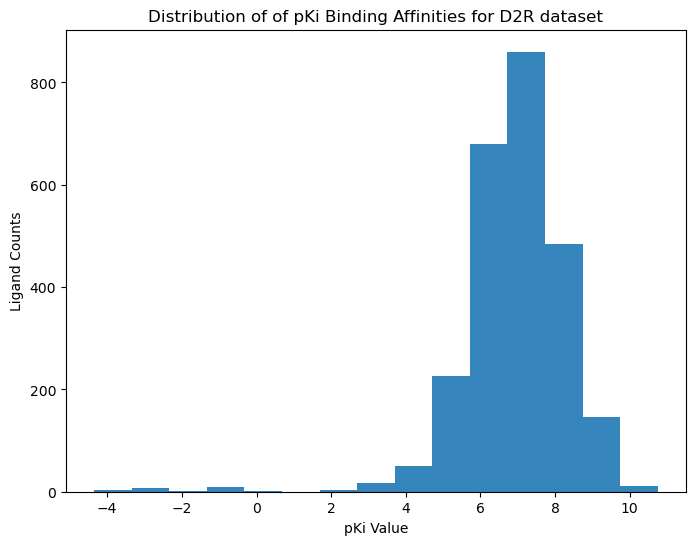

In [28]:
plt.figure(figsize=(8, 6))
plt.hist(data['target'], bins=15, range=(data['target'].min(), data['target'].max()), alpha=0.9)
plt.title('Distribution of of pKi Binding Affinities for D2R dataset')
plt.ylabel('Ligand Counts')
plt.xlabel('pKi Value')
plt.show()

## Pretrain the Chemprop Model using D2R dataset

In [ ]:
start_time = time.time()

# Define pre-training arguments
pretrain_arguments = [
    # Load the pre-train dataset
    '--data_path', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/pre_train_data.csv', 
    '--dataset_type', 'regression',  
    # Save the pre-trained model to the specified directory
    '--save_dir', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/pretrained_model', 
    '--batch_size', '10', 
    '--epochs', '30',  
    '--loss_function', 'mve'
]

# Parse the pre-train arguments
pretrain_args = chemprop.args.TrainArgs().parse_args(pretrain_arguments)
pretrain_args.quiet = True
mean_score, std_score = chemprop.train.cross_validate(args=pretrain_args, train_func=chemprop.train.run_training)

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time  
print(f"Execution time to pre-train the chemprop model : {execution_time:.2f} seconds")


## Random Sampling

In [ ]:
def run_chemprop(batchsize):

    # Define training arguments
    train_arguments = [
        '--data_path', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/rand_train_dataset.csv',
        '--dataset_type', 'regression',
        # Load the pre-trained model from the specified directory
        '--checkpoint_dir', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/pretrained_model',
        '--save_dir', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/fine_tuned_model_random_sampling',
        '--batch_size', str(batchsize), 
        '--loss_function', 'mve',
        '--epochs', str(30),
        
    ]

    # Parse training arguments
    train_args = chemprop.args.TrainArgs().parse_args(train_arguments)
    train_args.quiet = True
    mean_score, std_score = chemprop.train.cross_validate(args=train_args, train_func=chemprop.train.run_training)

    # Define test arguments
    test_arguments = [
    '--test_path', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/rand_test_dataset.csv',
    '--preds_path', 'rand_preds.csv',
    '--checkpoint_dir','/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/', 
    ]   

    # Parse test arguments
    test_args = chemprop.args.PredictArgs().parse_args(test_arguments)
    test_args.quiet = True
    preds = chemprop.train.make_predictions(args=test_args)

    # Get the predictions of binding affinity values
    preds = pd.read_csv("rand_preds.csv")
    y_preds = [[target] for target in preds["target"].values]
    test = pd.read_csv("rand_test_dataset.csv")
    y_test = [[target] for target in test["target"].values]
    dataset_type = 'test'
    num_tasks = len(y_preds[0])
    # Evaluate the predictions using RMSE and R2
    results = evaluate_predictions(preds=y_preds, targets=y_test, num_tasks=num_tasks, metrics=['rmse', 'r2'], dataset_type=dataset_type)
  
    return results['rmse'], results['r2']

In [ ]:
def random_sampling_chemprop(batchsize):
    seeds = [1, 2, 3]
    
    rmse_vals = []
    r2_vals = []

    # Get the data 
    data = pd.read_csv("TYK2_final.csv", index_col=False)
    # Drop the unnecessary cols from the dataset
    data = data.drop(['target', 'top_2p', 'top_5p'], axis=1)
    column_names = ['smiles', 'target']
    data.columns = column_names

    for seed in seeds:
        rmse_instance = []
        r2_instance = []
        
        data = np.array(data)
        shuffled_data = shuffle(data, random_state=seed)
        size = int(len(shuffled_data)*0.1)
        # Split into train and test (remaining)
        train, test = shuffled_data[:size], shuffled_data[size:]
        train_df = pd.DataFrame(train, columns=column_names)
        # Save the train set and test set as separate csvs that will get iteratively updated througout the simulation
        train_df.to_csv("rand_train_dataset.csv", index=False)
        test_df = pd.DataFrame(test, columns=column_names)
        test_df.to_csv("rand_test_dataset.csv", index=False)
        
        counter = 0
        # Run until the train set has 1500 data points
        while len(train_df) <= 1500:
            # Record metric values every 50 instances
            if counter % 50 == 0:
                print("running chemprop")
                rmse, r2 = run_chemprop(batchsize) 
                rmse_instance.append(rmse)
                r2_instance.append(r2)
            # Add the chosen instances to the training set for the specified batchsize
            train_df =  pd.concat([train_df, test_df.iloc[:batchsize]])
            # Drop the chosen instances from the remaining   
            test_df = test_df.drop(test_df.index[:batchsize]) 
            
            # Update the csv
            train_df.to_csv("rand_train_dataset.csv", index=False)
            test_df.to_csv("rand_test_dataset.csv", index=False)
            
            counter += batchsize
        
        rmse_vals.append(rmse_instance)
        r2_vals.append(r2_instance)
        print("finished seed")

    return rmse_vals, r2_vals


In [ ]:
start_time = time.time()

# Run Random Sampling for Chemprop for batch size 50 and record its runtime

batch_sizes = [100]
rand_rmse_dict = {}
rand_r2_dict = {}


for batch in batch_sizes:
    print(f"Batch Size: {batch}")
    rand_rmse, rand_r2 = random_sampling_chemprop(batch)
    print(f"finished all three seeds for batch size: {batch}")
    
    # RMSE Values
    rand_rmse_mean = np.mean(rand_rmse, axis=0)
    rand_rmse_stdev = np.std(rand_rmse, axis=0)
    print("mean:", rand_rmse_mean)
    print("standard deviation:", rand_rmse_stdev)
    rand_rmse_dict[batch] = (rand_rmse_mean, rand_rmse_stdev)
    

    # R2 Values
    rand_r2_mean = np.mean(rand_r2, axis=0)
    rand_r2_stdev = np.std(rand_r2, axis=0)
    print("mean:", rand_r2_mean)
    print("standard deviation:", rand_r2_stdev)
    rand_r2_dict[batch] = (rand_r2_mean, rand_r2_stdev)

print(rand_rmse_dict)
print(rand_r2_dict)

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time  
print(f"Execution time to run random sampling using the chemprop model: {execution_time:.2f} seconds")

In [ ]:
start_time = time.time()

# Run Random Sampling for Chemprop for batch size 100 and record its runtime
batch_sizes = [100]
rand_rmse_dict = {}
rand_r2_dict = {}


for batch in batch_sizes:
    print(f"Batch Size: {batch}")
    rand_rmse, rand_r2 = random_sampling_chemprop(batch)
    print(f"finished all three seeds for batch size: {batch}")
    
    # RMSE Values
    rand_rmse_mean = np.mean(rand_rmse, axis=0)
    rand_rmse_stdev = np.std(rand_rmse, axis=0)
    print("mean:", rand_rmse_mean)
    print("standard deviation:", rand_rmse_stdev)
    rand_rmse_dict[batch] = (rand_rmse_mean, rand_rmse_stdev)
    

    # R2 Values
    rand_r2_mean = np.mean(rand_r2, axis=0)
    rand_r2_stdev = np.std(rand_r2, axis=0)
    print("mean:", rand_r2_mean)
    print("standard deviation:", rand_r2_stdev)
    rand_r2_dict[batch] = (rand_r2_mean, rand_r2_stdev)

print(rand_rmse_dict)
print(rand_r2_dict)

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time  
print(f"Execution time to run random sampling using the chemprop model: {execution_time:.2f} seconds")

## Uncertainty Sampling using Monte Carlo Dropout

In [ ]:
def chemprop_monte_carlo(batchsize, eval):
    
    # Define training arguments
    train_arguments = [
        '--data_path', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/mc_train_dataset.csv',
        '--dataset_type', 'regression',
        # Load the pre-trained model from the specified directory
        '--checkpoint_dir', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/pretrained_model',
        '--save_dir', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/fine_tuned_model',
        '--batch_size', str(batchsize), 
        '--loss_function', 'mve', 
        '--epochs', str(30),
        
    ]

    # Parse training arguments
    train_args = chemprop.args.TrainArgs().parse_args(train_arguments)
    train_args.quiet = True
    mean_score, std_score = chemprop.train.cross_validate(args=train_args, train_func=chemprop.train.run_training)

    # Define test arguments
    test_arguments = [
    '--test_path', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/mc_test_dataset.csv',
    '--preds_path', 'mc_preds.csv',
    '--checkpoint_dir', '/Users/sinhanushka_/Documents/GitHub/02-750-Final-Project/',
    '--uncertainty_dropout_p', str(0.1), 
    '--uncertainty_method', 'mve',
    ]   

    # Parse test arguments
    test_args = chemprop.args.PredictArgs().parse_args(test_arguments)
    test_args.quiet = True
    
    # Get predictions on binding affinity values 
    preds = chemprop.train.make_predictions(args=test_args, return_uncertainty=True)
    preds = pd.read_csv("mc_preds.csv")
    # Get the uncertainty values 
    uncertainty = preds['target_mve_uncal_var']
    # Choose the instances with the largest uncertainty
    instance_to_add = uncertainty.nlargest(batchsize).index
    
    if eval == True:
        y_preds = [[target] for target in preds["target"].values]
        test = pd.read_csv("mc_test_dataset.csv")
        y_test = [[target] for target in test["target"].values]
        dataset_type = 'test'
        num_tasks = len(y_preds[0])
        results = evaluate_predictions(preds=y_preds, targets=y_test, num_tasks=num_tasks, metrics=['rmse', 'r2'], dataset_type=dataset_type)
        return instance_to_add, results['rmse'], results['r2']
    
    return instance_to_add
  
    

In [ ]:
def monte_carlo_dropout(batchsize):
    seeds = [1, 2, 3]
    
    rmse_vals = []
    r2_vals = []

    data = pd.read_csv("TYK2_final.csv", index_col=False)
    data = data.drop(['target', 'top_2p', 'top_5p'], axis=1)
    column_names = ['smiles', 'target']
    data.columns = column_names

    for seed in seeds:
        rmse_instance = []
        r2_instance = []
        
        data = np.array(data)
        shuffled_data = shuffle(data, random_state=seed)
        size = 1000
        # Split into train and test (remaining)
        train, test = shuffled_data[:size], shuffled_data[size:]
        # Save the train set and test set as separate csvs that will get iteratively updated througout the simulation
        train_df = pd.DataFrame(train, columns=column_names)
        train_df.to_csv("mc_train_dataset.csv", index=False)
        test_df = pd.DataFrame(test, columns=column_names)
        test_df.to_csv("mc_test_dataset.csv", index=False)
          

        counter = 0
        eval = False
        while len(train_df) <= 1500:
            # Record metric values every 50 instances for the specified batch size
            if counter % 50 == 0:
                eval = True 
                instance, rmse, r2 = chemprop_monte_carlo(batchsize, eval) 
                rmse_instance.append(rmse)
                r2_instance.append(r2)
            
            else:
                instance = chemprop_monte_carlo(batchsize, eval) 

            eval = False

            # Add the chosen instances to the training set for the specified batchsize
            train_df =  pd.concat([train_df, test_df.iloc[instance]])  
            # Drop the chosen instances from the remaining  
            test_df = test_df.drop(test_df.index[instance]) 
    
            # Update the csv
            train_df.to_csv("mc_train_dataset.csv", index=False)
            test_df.to_csv("mc_test_dataset.csv", index=False)

            counter += batchsize
        
        rmse_vals.append(rmse_instance)
        r2_vals.append(r2_instance)
      
    return rmse_vals, r2_vals

In [ ]:
start_time = time.time()

# Run Uncertainty Sampling for Chemprop for batch size 50 and record its runtime

batch_sizes = [50]
mc_rmse_dict = {}
mc_r2_dict = {}


for batch in batch_sizes:
    print(f"batch: {batch}")
    mc_rmse, mc_r2 = monte_carlo_dropout(batch)
    print(f"finished all three seeds for batch size: {batch}")
    
    # RMSE Values
    mc_rmse_mean = np.mean(mc_rmse, axis=0)
    mc_rmse_stdev = np.std(mc_rmse, axis=0)
    print("mean:", mc_rmse_mean)
    print("standard deviation:", mc_rmse_stdev)
    mc_rmse_dict[batch] = (mc_rmse_mean, mc_rmse_stdev)

    # R2 Values
    mc_r2_mean = np.mean(mc_r2, axis=0)
    mc_r2_stdev = np.std(mc_r2, axis=0)
    print("mean:", mc_r2_mean)
    print("standard deviation:", mc_r2_stdev)
    mc_r2_dict[batch] = (mc_r2_mean, mc_r2_stdev)
  
print(mc_rmse_dict)
print(mc_r2_dict)

end_time = time.time()
execution_time = end_time - start_time  
print(f"Execution time to run random sampling using the chemprop model: {execution_time:.2f} seconds")


In [ ]:
start_time = time.time()

# Run Uncertainty Sampling for Chemprop for batch size 100 and record its runtime

batch_sizes = [100]
mc_rmse_dict = {}
mc_r2_dict = {}


for batch in batch_sizes:
    print(f"batch: {batch}")
    mc_rmse, mc_r2 = monte_carlo_dropout(batch)
    print(f"finished all three seeds for batch size: {batch}")
    
    # RMSE Values
    mc_rmse_mean = np.mean(mc_rmse, axis=0)
    mc_rmse_stdev = np.std(mc_rmse, axis=0)
    print("mean:", mc_rmse_mean)
    print("standard deviation:", mc_rmse_stdev)
    mc_rmse_dict[batch] = (mc_rmse_mean, mc_rmse_stdev)
   
    # R2 Values
    mc_r2_mean = np.mean(mc_r2, axis=0)
    mc_r2_stdev = np.std(mc_r2, axis=0)
    print("mean:", mc_r2_mean)
    print("standard deviation:", mc_r2_stdev)
    mc_r2_dict[batch] = (mc_r2_mean, mc_r2_stdev)
   
print(mc_rmse_dict)
print(mc_r2_dict)

end_time = time.time()
execution_time = end_time - start_time  
print(f"Execution time to run random sampling using the chemprop model: {execution_time:.2f} seconds")